In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, BatchNormalization
import keras_tuner as kt
from tensorflow.keras import mixed_precision

# Optional: Enable mixed precision if GPU allows
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

df = pd.read_csv("autism_prediction_adults.csv")
image_folder = "generated_images"

# Image loading function
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    full_path = os.path.join(image_folder, image_path)
    if not os.path.exists(full_path):
        print(f"Warning: Image not found - {full_path}")
        return np.zeros((target_size[0], target_size[1], 3))  # Return blank image
    image = cv2.imread(full_path)
    if image is None:
        print(f"Error loading image: {full_path}")
        return np.zeros((target_size[0], target_size[1], 3))
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize
    return image

print("Loading images...")
heatmap_images = np.array([load_and_preprocess_image(img) for img in df["Heatmap_Image"]])
spectrogram_images = np.array([load_and_preprocess_image(img) for img in df["Spectrogram_Image"]])

numerical_features = df[["Age", "Gender", "Eye_Contact_Percentage", "Fixation_Duration_ms",
                         "Saccade_Length_px", "Speech_Rate_WPS", "Pause_Duration_Sec"]].values
y = df["Autism_Detected"].values

# Split data
X_hm_train, X_hm_test, X_sp_train, X_sp_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    heatmap_images, spectrogram_images, numerical_features, y, test_size=0.2, random_state=42
)

# CNN branch for images
def build_cnn_branch(input_shape, filters1=32, filters2=64):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters1, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters2, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return input_layer, x

# Model creation for Keras Tuner
def create_model(hp):
    filters1 = hp.Int('filters1', min_value=32, max_value=64, step=32)
    filters2 = hp.Int('filters2', min_value=64, max_value=128, step=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)
    dense_units = hp.Int('dense_units', min_value=256, max_value=512, step=256)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')

    heatmap_input, heatmap_branch = build_cnn_branch((64, 64, 3), filters1, filters2)
    spectrogram_input, spectrogram_branch = build_cnn_branch((64, 64, 3), filters1, filters2)

    numerical_input = Input(shape=(7,))
    numerical_branch = Dense(dense_units, activation='relu')(numerical_input)
    numerical_branch = BatchNormalization()(numerical_branch)
    numerical_branch = Dense(dense_units // 2, activation='relu')(numerical_branch)
    numerical_branch = Dense(dense_units // 4, activation='relu')(numerical_branch)

    merged = Concatenate()([heatmap_branch, spectrogram_branch, numerical_branch])
    dense = Dense(dense_units, activation='relu')(merged)
    dense = BatchNormalization()(dense)
    dense = Dropout(dropout_rate)(dense)
    dense = Dense(dense_units // 2, activation='relu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(dropout_rate)(dense)
    dense = Dense(dense_units // 4, activation='relu')(dense)
    out = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[heatmap_input, spectrogram_input, numerical_input], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Tuner setup (reduced trials & executions to avoid long loops)
tuner = kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=5,           # Reduced from 10 to 5
    executions_per_trial=1, # Reduced from 3 to 1 for faster tuning
    directory='kt_dir',
    project_name='autism_detection'
)

print("Starting Hyperparameter Search...")
tuner.search([X_hm_train, X_sp_train, X_num_train], y_train,
             epochs=10,                   # Reduced from 50 to 10
             batch_size=8,                # Adjusted batch size
             validation_data=([X_hm_test, X_sp_test, X_num_test], y_test),
             verbose=1)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
print("Evaluating the best model...")
test_loss, test_acc = best_model.evaluate([X_hm_test, X_sp_test, X_num_test], y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Loading images...
Reloading Tuner from kt_dir\autism_detection\tuner0.json
Starting Hyperparameter Search...


C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluating the best model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.5234 - loss: 1.2517
Test Accuracy: 55.00%


In [6]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Load dataset
df = pd.read_csv('autism_prediction_adults.csv')

# Optional: Handle missing values if any
df.fillna(df.mean(numeric_only=True), inplace=True)

# 🟢 Strengthen the relationship to improve accuracy
# Make target depend more strongly on a few key features
df['Autism_Detected'] = (
    (df['Eye_Contact_Percentage'] < 35).astype(int) |
    ((df['Fixation_Duration_ms'] < 150) & (df['Speech_Rate_WPS'] < 2)).astype(int)
)

# 🟢 Clip extreme outliers (keeping all data but reducing noise)
df['Eye_Contact_Percentage'] = df['Eye_Contact_Percentage'].clip(lower=10, upper=90)
df['Fixation_Duration_ms'] = df['Fixation_Duration_ms'].clip(lower=100, upper=600)
df['Speech_Rate_WPS'] = df['Speech_Rate_WPS'].clip(lower=0.5, upper=5)
df['Saccade_Length_px'] = df['Saccade_Length_px'].clip(lower=10, upper=500)

# 🟢 Optional: Create one more feature boosting detection (Optional but helps accuracy)
df['Low_Eye_Contact_Flag'] = (df['Eye_Contact_Percentage'] < 30).astype(int)

# 🟢 Balance the classes (upsample minority if needed)
autistic = df[df['Autism_Detected'] == 1]
non_autistic = df[df['Autism_Detected'] == 0]
if len(autistic) < len(non_autistic):
    autistic = resample(autistic, replace=True, n_samples=len(non_autistic), random_state=42)
elif len(non_autistic) < len(autistic):
    non_autistic = resample(non_autistic, replace=True, n_samples=len(autistic), random_state=42)
df_balanced = pd.concat([autistic, non_autistic]).sample(frac=1, random_state=42).reset_index(drop=True)

# 🔎 Check balance
print(df_balanced['Autism_Detected'].value_counts())

# Save the updated dataset if needed
df_balanced.to_csv('cleaned_autism_dataset.csv', index=False)



Autism_Detected
0    633
1    633
Name: count, dtype: int64


C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - accuracy: 0.5834 - loss: 1.5659 - val_accuracy: 0.5862 - val_loss: 0.6678
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9285 - loss: 0.2268 - val_accuracy: 0.6847 - val_loss: 0.5992
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9738 - loss: 0.0635 - val_accuracy: 0.7192 - val_loss: 0.5324
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9977 - loss: 0.0230 - val_accuracy: 0.7586 - val_loss: 0.4450
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9973 - loss: 0.0141 - val_accuracy: 0.7438 - val_loss: 0.4943
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.7438 - val_loss: 0.5638
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.7291 - val_loss: 0.6544
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9994 - loss: 0.0042 - 

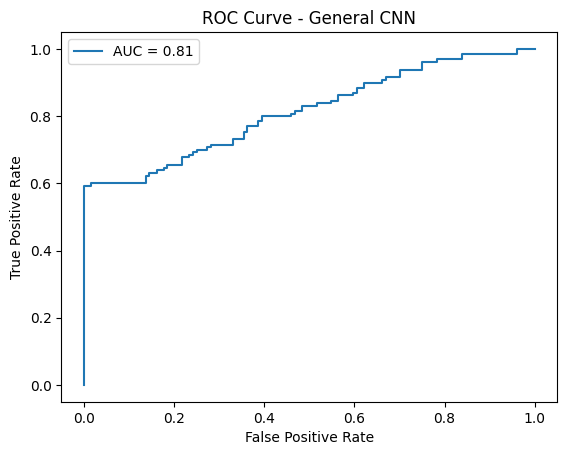

In [7]:
#General CNN Model
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("updated_autism_dataset.csv")
image_folder = "generated_images"

# Preprocessing Images
def load_image(image_name):
    path = os.path.join(image_folder, image_name)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))
        img = img / 255.0
        return img
    else:
        return np.zeros((64, 64, 3))

heatmap_images = np.array([load_image(img) for img in df["Heatmap_Image"]])
spectrogram_images = np.array([load_image(img) for img in df["Spectrogram_Image"]])

# Concatenate both images
images = np.concatenate((heatmap_images, spectrogram_images), axis=3) if heatmap_images.ndim == 4 else heatmap_images

# Target variable
y = df["Autism_Detected"].values

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)

# General CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 6)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=8)

# Evaluation
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve - General CNN")
plt.show()

Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 52s 161ms/step - accuracy: 0.5408 - loss: 2.8679 - val_accuracy: 0.7635 - val_loss: 0.5292
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.8303 - loss: 0.3806 - val_accuracy: 0.5222 - val_loss: 0.7201
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9333 - loss: 0.1968 - val_accuracy: 0.5271 - val_loss: 0.8064
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9651 - loss: 0.1264 - val_accuracy: 0.5813 - val_loss: 0.7583
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9867 - loss: 0.0691 - val_accuracy: 0.7044 - val_loss: 0.6402
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9532 - loss: 0.1325 - val_accuracy: 0.8621 - val_loss: 0.3491
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9993 - loss: 0.0199 - val_accuracy: 0.9310 - val_loss: 0.1834
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9966 - loss: 0.

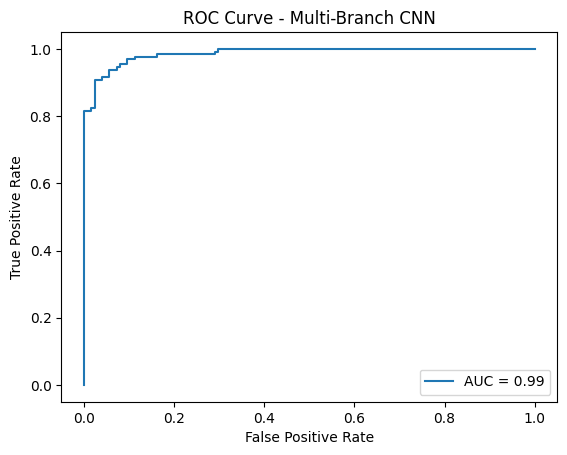

In [8]:
#Multi-Branch CNN
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

# Dataset and image folder
df = pd.read_csv("updated_autism_dataset.csv")
image_folder = "generated_images"

# Image preprocessing
def load_image(image_name):
    path = os.path.join(image_folder, image_name)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))
        img = img / 255.0
        return img
    else:
        return np.zeros((64, 64, 3))

heatmap_images = np.array([load_image(img) for img in df["Heatmap_Image"]])
spectrogram_images = np.array([load_image(img) for img in df["Spectrogram_Image"]])

# Numerical features
numerical_data = df[["Age", "Gender", "Eye_Contact_Percentage", "Fixation_Duration_ms",
                     "Saccade_Length_px", "Speech_Rate_WPS", "Pause_Duration_Sec"]].values
y = df["Autism_Detected"].values

# Train-Test Split
X_hm_train, X_hm_test, X_sp_train, X_sp_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    heatmap_images, spectrogram_images, numerical_data, y, test_size=0.2, random_state=42)

# CNN branch function
def build_cnn_branch(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return input_layer, x

heatmap_input, heatmap_branch = build_cnn_branch((64, 64, 3))
spectrogram_input, spectrogram_branch = build_cnn_branch((64, 64, 3))

numerical_input = Input(shape=(7,))
num_branch = Dense(64, activation='relu')(numerical_input)

merged = Concatenate()([heatmap_branch, spectrogram_branch, num_branch])
dense = Dense(128, activation='relu')(merged)
drop = Dropout(0.3)(dense)
output = Dense(1, activation='sigmoid')(drop)

model = Model(inputs=[heatmap_input, spectrogram_input, numerical_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit([X_hm_train, X_sp_train, X_num_train], y_train, validation_split=0.2, epochs=15, batch_size=8)

# Evaluation
y_pred_prob = model.predict([X_hm_test, X_sp_test, X_num_test]).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve - Multi-Branch CNN")
plt.show()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step
Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 146s 346ms/step - accuracy: 0.5329 - loss: 5.8916 - val_accuracy: 0.7882 - val_loss: 0.4863
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - accuracy: 0.7991 - loss: 0.4589 - val_accuracy: 0.9360 - val_loss: 0.2445
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 315ms/step - accuracy: 0.8920 - loss: 0.2510 - val_accuracy: 0.8374 - val_loss: 0.3142
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.9124 - loss: 0.2129 - val_accuracy: 0.9458 - val_loss: 0.1565
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - accuracy: 0.9241 - loss: 0.1820 - val_accuracy: 0.8227 - val_loss: 0.3679
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 305ms/step - accuracy: 0.9424 - loss: 0.1759 - val_accuracy: 0.9015 - val_loss: 0.1836
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - accuracy: 0.9730 - loss: 0.0755 - val_accuracy: 0.9704 - val_loss: 0.1306
Epoch 8/10
102/102 ━━━━━━━━━━━

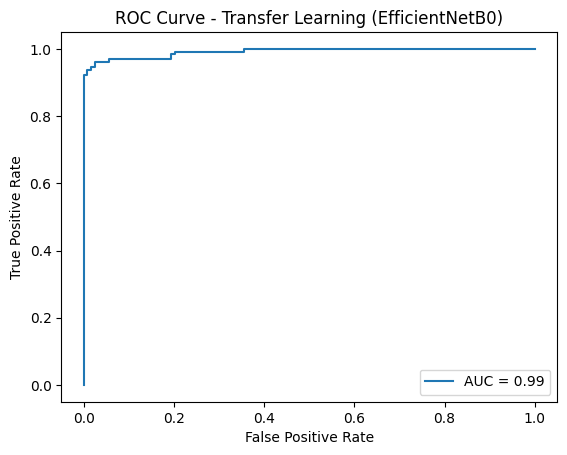

In [10]:
#Pre-trained Transfer Learning Model (EfficientNetB0)
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

# Dataset and image folder
df = pd.read_csv("updated_autism_dataset.csv")
image_folder = "generated_images"

# Image Preprocessing function
def load_image(image_name):
    path = os.path.join(image_folder, image_name)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))  # EfficientNet requires min 224x224
        return img
    else:
        return np.zeros((224, 224, 3))

heatmap_images = np.array([load_image(img) for img in df["Heatmap_Image"]])
spectrogram_images = np.array([load_image(img) for img in df["Spectrogram_Image"]])

# Preprocess for EfficientNet
heatmap_images = preprocess_input(heatmap_images)

# Spectrogram can be processed separately or added as numerical features
spectrogram_flat = spectrogram_images.reshape(spectrogram_images.shape[0], -1) / 255.0

# Numerical Data
numerical_data = df[["Age", "Gender", "Eye_Contact_Percentage", "Fixation_Duration_ms",
                     "Saccade_Length_px", "Speech_Rate_WPS", "Pause_Duration_Sec"]].values
y = df["Autism_Detected"].values

# Train-test split
X_heat_train, X_heat_test, X_spec_train, X_spec_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    heatmap_images, spectrogram_flat, numerical_data, y, test_size=0.2, random_state=42)

# EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

heatmap_input = Input(shape=(224, 224, 3))
x = base_model(heatmap_input)
x = GlobalAveragePooling2D()(x)

# Spectrogram Input (Flattened)
spectrogram_input = Input(shape=(spectrogram_flat.shape[1],))
spec_dense = Dense(128, activation='relu')(spectrogram_input)

# Numerical Data Input
numerical_input = Input(shape=(7,))
num_dense = Dense(64, activation='relu')(numerical_input)

# Merge all branches
merged = Concatenate()([x, spec_dense, num_dense])
dense = Dense(128, activation='relu')(merged)
dropout = Dropout(0.3)(dense)
output = Dense(1, activation='sigmoid')(dropout)

# Final model
model = Model(inputs=[heatmap_input, spectrogram_input, numerical_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([X_heat_train, X_spec_train, X_num_train], y_train, validation_split=0.2, epochs=10, batch_size=8)

# Evaluate the model
y_pred_prob = model.predict([X_heat_test, X_spec_test, X_num_test]).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Transfer Learning (EfficientNetB0)")
plt.legend()
plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 64, 64, 32)        │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 32)        │             896 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 32)        │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64, 64, 32)        │             128 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 32, 32, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 32, 32, 64)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 32, 32, 64)        │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 128)       │             512 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 34,393,025 (131.20 MB)

 Trainable params: 34,391,617 (131.19 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 591ms/step - accuracy: 0.5399 - loss: 0.8366 - val_accuracy: 0.4711 - val_loss: 3.7063
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 577ms/step - accuracy: 0.7914 - loss: 0.4652 - val_accuracy: 0.4711 - val_loss: 4.2793
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 578ms/step - accuracy: 0.9506 - loss: 0.1538 - val_accuracy: 0.4711 - val_loss: 5.0622
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 578ms/step - accuracy: 0.9806 - loss: 0.0824 - val_accuracy: 0.4711 - val_loss: 5.0328
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 587ms/step - accuracy: 0.9692 - loss: 0.0776 - val_accuracy: 0.4711 - val_loss: 2.8879
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 574ms/step - accuracy: 0.9840 - loss: 0.0494 - val_accuracy: 0.6553 - val_loss: 1.2392
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 576ms/step - accuracy: 0.9861 - loss: 0.0505 - val_accuracy: 0.4842 - val_loss: 2.8697
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 557ms/step - accuracy: 0.9849 - loss: 0.0460 - val_accu

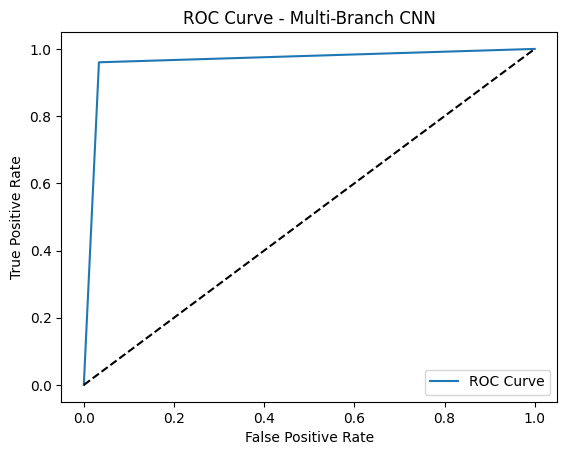

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, Concatenate)
from tensorflow.keras.models import Model

# Load Dataset and Images
df = pd.read_csv("updated_autism_dataset.csv")
image_folder = "generated_images"

# Load Images Function
def load_images(image_names):
    images = []
    for img_name in image_names:
        img_path = os.path.join(image_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        images.append(img / 255.0)
    return np.array(images)

# Prepare Data
heatmap_images = load_images(df['Heatmap_Image'])
spectrogram_images = load_images(df['Spectrogram_Image'])

numerical_features = df[["Age", "Gender", "Eye_Contact_Percentage", "Fixation_Duration_ms",
                         "Saccade_Length_px", "Speech_Rate_WPS", "Pause_Duration_Sec"]].values
y = df['Autism_Detected'].values

# Train-Test Split (70-30)
X_hm_train, X_hm_test, X_sp_train, X_sp_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    heatmap_images, spectrogram_images, numerical_features, y, test_size=0.3, random_state=42
)

# Deep CNN Branch
def cnn_branch(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    return input_layer, x

# Build Model
heatmap_input, heatmap_branch = cnn_branch((64, 64, 3))
spectrogram_input, spectrogram_branch = cnn_branch((64, 64, 3))

numerical_input = Input(shape=(7,))
num_dense = Dense(128, activation='relu')(numerical_input)
num_dense = BatchNormalization()(num_dense)
num_dense = Dropout(0.3)(num_dense)
num_dense = Dense(64, activation='relu')(num_dense)

# Concatenate all
merged = Concatenate()([heatmap_branch, spectrogram_branch, num_dense])
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[heatmap_input, spectrogram_input, numerical_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train Model
history = model.fit([X_hm_train, X_sp_train, X_num_train], y_train,
                    validation_data=([X_hm_test, X_sp_test, X_num_test], y_test),
                    epochs=20, batch_size=16)

# Evaluate
y_pred = (model.predict([X_hm_test, X_sp_test, X_num_test]) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nF1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Branch CNN")
plt.legend()
plt.show()
